# Retrieve sonar data

In [1]:
%%capture
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import pickle

from echogram import EchoGram

### Old Datasets:
- './log-data/Sonar_2021-10-16_12.53.38.sl2'    
- './log-data/Sonar_2021-10-16_13.29.30.sl2'
- './log-data/Sonar_2021-10-16_13.29.36.sl2'
- './log-data/Sonar_2021-10-16_14.21.09.sl2'
- './log-data/Sonar_2021-10-16_14.38.24.sl2'

### Channel (sonar sensor type)
- 0 = Primary (Traditional Sonar)
- 1 = Secondary (Traditional Sonar)
- 2 = DSI (Downscan Imaging)
- 3 = Sidescan Left
- 4 = Sidescan Right
- 5 = Sidescan (Composite)
Another other value is treated as Invalid.

## Object testing 2 (July 2022)

In [2]:
with open('processed_data/echo_1_072122.txt', 'rb') as fl:
    echo_1_072122 = pickle.load(fl)
with open('processed_data/echo_2_072122.txt', 'rb') as fl:
    echo_2_072122 = pickle.load(fl)

## Force sensor data (May 2022)

In [3]:
with open('processed_data/echo_1_051722.txt', 'rb') as fl:
    echo_1_051722 = pickle.load(fl)
with open('processed_data/echo_2_051722.txt', 'rb') as fl:
    echo_2_051722 = pickle.load(fl)

In [4]:
import copy
echo_3_051722 = copy.deepcopy(echo_1_051722)
echo_6_051722 = copy.deepcopy(echo_1_051722)
echo_9_051722 = copy.deepcopy(echo_1_051722)
echo_12_051722 = copy.deepcopy(echo_2_051722)

In [5]:
echo_3_051722.crop_data(0, 800) 
echo_3_051722.crop_data(-1, 9100 - len(echo_3_051722.df), -1) 
echo_6_051722.crop_data(0, 11700) 
echo_6_051722.crop_data(-1, 5200 - len(echo_6_051722.df), -1) 
echo_9_051722.crop_data(0, 11700 + 5200) 
echo_9_051722.crop_data(0, 1000) 
echo_9_051722.crop_data(-1, 3450 - len(echo_9_051722.df), -1) 
echo_12_051722.crop_data(0, 6700)

## February 2022 data

In [6]:
import os
files = os.listdir('log-data/02_20_22')
print(files)

['Sonar_2022-01-20_16.16.03.sl2', 'Sonar_2022-01-20_10.45.23.sl2', 'Sonar_2022-01-20_09.53.33.sl2', 'Sonar_2022-01-20_15.54.19.sl2', 'Sonar_2022-01-20_11.05.09.sl2']


In [7]:
with open('processed_data/dataset_012022.txt', 'rb') as fl:
    dataset_012022 = pickle.load(fl)
with open('processed_data/cropped_dataset.txt', 'rb') as fl:
    cropped_dataset = pickle.load(fl)

## October 2021 data

In [8]:
#echogram6mph = EchoGram('./log-data-lowrance/Sonar_2021-10-16_13.29.36.sl2', channels=[5])
with open('processed_data/echogram6mph_101621.txt', 'rb') as file:
    # Call load method to deserialze
    echogram6mph = pickle.load(file)

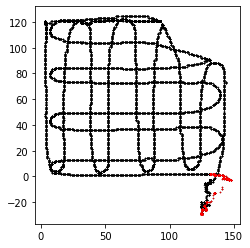

In [9]:
echogram6mph.see_range([-800, -1])

In [10]:
echogram6mph.crop_data(0,2200)
echogram6mph.crop_data(-1, -800, -1) # start from -1 to delete the last element 

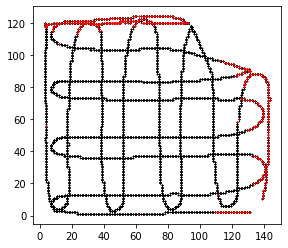

In [11]:
fig, ax = plt.subplots()
ax.plot(echogram6mph.X, echogram6mph.Y, 'ko', ms=0.5)
ax.plot(echogram6mph.X[echogram6mph.df['water_depth_m']< 0.00001], echogram6mph.Y[echogram6mph.df['water_depth_m']< 0.00001], 'ro', ms=0.5)
ax.set_aspect('equal')

echogram6mph.crop_data(None, None, step=None, use_conditional=True, condition=echogram6mph.df['water_depth_m']< 0.00001)

length:  17675


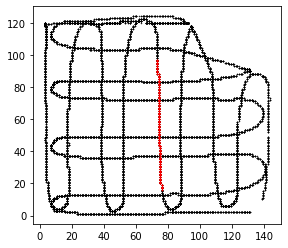

In [12]:
image_start = 3200 #3500
image_end = 3800 #4100
df2 = echogram6mph.df
print("length: ",len(df2['longitude']))
echogram6mph.see_range([image_start,image_end])

### Start manipulating data

In [13]:
def lat_lon_to_meters(lon, lat):
        """ Convert longitude and latitude to global X and Y coordinates in meters
        """
        # Using Spherical Pseudo-Mercator projection
        # https://wiki.openstreetmap.org/wiki/Mercator
        R =  6378137.0
        Y = np.log(np.tan(np.pi / 4 + np.radians(lat) / 2)) * R
        X = np.radians(lon) * R
        X = X - X[0]
        Y = Y - Y[0]
        return X, Y
    
def get_distance(x,y):
    """calculates the euclidean distance for a sequence of points in the x and y coordinate
    """
    dx = np.diff(x)
    dy = np.diff(y)
    return np.add.accumulate(np.sqrt(dx**2 + dy**2))

In [14]:
# October21 data
X, Y = lat_lon_to_meters(df2["longitude"].to_numpy(), df2["latitude"].to_numpy())
df2["X_m"] = X
df2["Y_m"] = Y
distance = get_distance(X, Y)
distance = np.append(distance, distance[-1])
df2["distance_m"] = distance

In [15]:
# February22 data
for ii in range(len(files)):
    #cropped_dataset[files[ii]]
    distance = get_distance(cropped_dataset[files[ii]].df["X_m"], cropped_dataset[files[ii]].df["Y_m"])
    distance = np.append(distance, distance[-1])
    cropped_dataset[files[ii]].df["distance_m"] = distance

In [16]:
# May22 data TODO: FIX so that it changes variable in the list, not pointer
for df in [echo_3_051722.df, echo_6_051722.df, echo_9_051722.df, echo_12_051722.df]:
    distance = get_distance(df["X_m"], df["Y_m"])
    distance = np.append(distance, distance[-1])
    df["distance_m"] = distance

In [17]:
# July22 data TODO: FIX so that it changes variable in the list, not pointer
for df in [echo_1_072122.df, echo_2_072122.df]:
    distance = get_distance(df["X_m"], df["Y_m"])
    distance = np.append(distance, distance[-1])
    df["distance_m"] = distance

## Scale intensity values using min max normalization and visualize

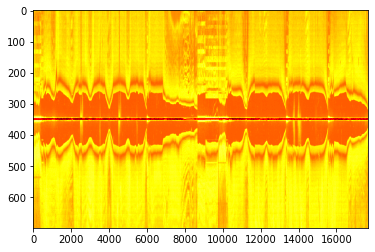

In [18]:
plt.imshow(echogram6mph.echo, cmap='hot',aspect='auto')

#### Visualize the October21 sonar image

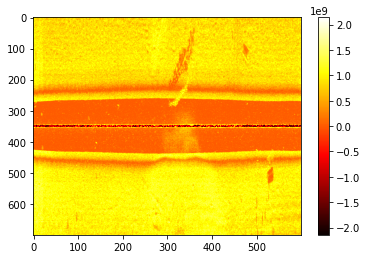

In [19]:
plt.imshow(echogram6mph.echo[:,image_start:image_end], cmap='hot',aspect='auto')
plt.colorbar()

In [20]:
for ii in range(len(files)):
    print("min: ",np.min(cropped_dataset[files[ii]].echo), end = ', ')
    print("max: ",np.max(cropped_dataset[files[ii]].echo))
print("min: ",np.min(echogram6mph.echo), end = ', ')
print("max: ",np.max(echogram6mph.echo))

min:  -2142603100.0, max:  2141233300.0
min:  -2141758100.0, max:  2141233300.0
min:  -2142805600.0, max:  2141233300.0
min:  -2141821800.0, max:  2141233300.0
min:  -2142998900.0, max:  2141233300.0
min:  -2142878100.0, max:  2141233300.0


In [21]:
## Parameters
middle_left = 326
middle_right = 374

sss shape:  (700, 17675)
min intensity= -2142878100.0
max intensity= 2141233300.0


Text(0.5, 0, 'Data points')

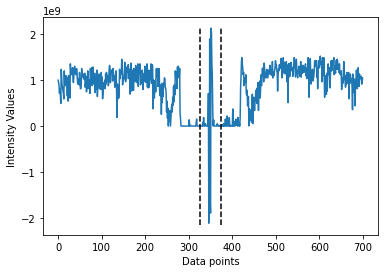

In [22]:
sss_intensity_raw = echogram6mph.echo
rows, columns = sss_intensity_raw.shape  
print("sss shape: ", sss_intensity_raw.shape)

vmin = np.min(sss_intensity_raw)
vmax = np.max(sss_intensity_raw)
print("min intensity=",vmin)
print("max intensity=",vmax)

fig, ax = plt.subplots()
ax.plot(range(rows),sss_intensity_raw[:,image_start+1000])  # single strip of data
ax.plot(np.array([middle_right]*2),[vmin,vmax], '--k', label='range')
ax.plot(np.array([middle_left]*2),[vmin,vmax], '--k', label='range')
ax.set_ylabel("Intensity Values")
ax.set_xlabel("Data points")

In [23]:
# Delete return on the middle of sss image
sss_intensity_raw[middle_left:middle_right, :] = 0
print("min intensity=",np.min(sss_intensity_raw))
print("max intensity=",np.max(sss_intensity_raw))

min intensity= 0.0
max intensity= 2021621600.0


Text(0.5, 0, 'Data points')

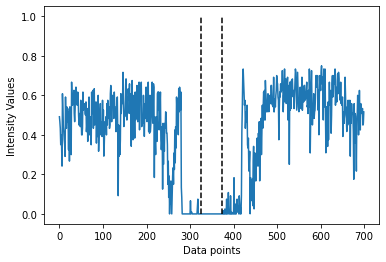

In [24]:
#sss = plt.imread('./images/sss.png') # image file, ndarray, with shape: (288, 432, 4)
vmin = np.min(sss_intensity_raw)
vmax = np.max(sss_intensity_raw)
sss_intensity_raw = (sss_intensity_raw - vmin) / (vmax - vmin) 
#sss_intensity_raw = (sss_intensity_raw + vmax) / (2*vmax)  #symmetric scaling

sss_intensity_raw[middle_left:middle_right, :] = 0
fig, ax = plt.subplots()
ax.plot(range(rows),sss_intensity_raw[:,image_start+1000])  # single strip of data
ax.plot(np.array([middle_right]*2),[0,1], '--k', label='range')
ax.plot(np.array([middle_left]*2),[0,1], '--k', label='range')
ax.set_ylabel("Intensity Values")
ax.set_xlabel("Data points")

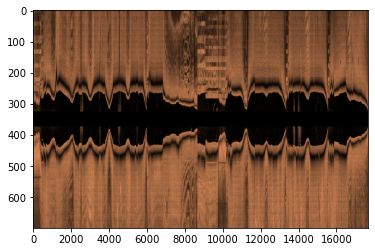

In [25]:
plt.imshow(sss_intensity_raw, cmap='copper',aspect='auto')

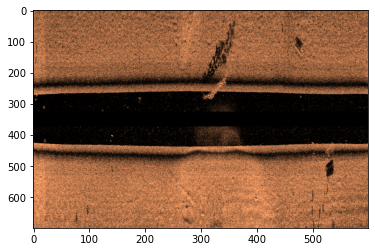

In [26]:
sss_intensity = sss_intensity_raw[:, image_start:image_end]
rows, columns = sss_intensity.shape  
plt.imshow(sss_intensity, cmap='copper',aspect='auto')

#### February 22

In [27]:
for ii in range(len(files)):
    cropped_dataset[files[ii]].echo[middle_left:middle_right, :] = 0
    vmin = np.min(cropped_dataset[files[ii]].echo)
    vmax = np.max(cropped_dataset[files[ii]].echo)
    print("min intensity=",vmin)
    cropped_dataset[files[ii]].echo = (cropped_dataset[files[ii]].echo - vmin) / (vmax - vmin)

min intensity= 0.0
min intensity= 0.0
min intensity= 0.0
min intensity= 0.0
min intensity= 0.0


#### May 22

In [28]:
for echo in [echo_3_051722.echo, echo_6_051722.echo, echo_9_051722.echo, echo_12_051722.echo]:
    echo[middle_left:middle_right, :] = 0
    vmin = np.min(echo)
    vmax = np.max(echo)
    print("min intensity=",vmin)
    echo = (echo - vmin) / (vmax - vmin)

min intensity= 0.0
min intensity= 0.0
min intensity= 0.0
min intensity= 0.0


In [29]:
for echo in [echo_1_072122.echo, echo_2_072122.echo]:
    echo[middle_left:middle_right, :] = 0
    vmin = np.min(echo)
    vmax = np.max(echo)
    print("min intensity=",vmin)
    echo = (echo - vmin) / (vmax - vmin)

min intensity= -2139062700.0
min intensity= -2139062900.0


## Visualize and select images with objects

#### October 21

/tmp/ipykernel_284/3188852807.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

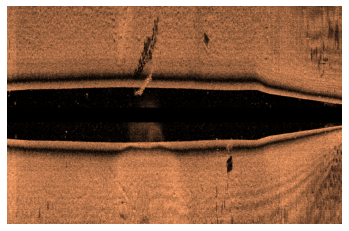

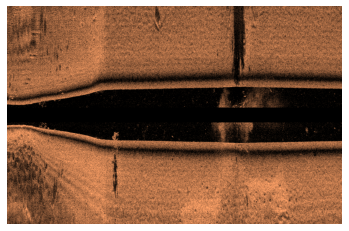

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

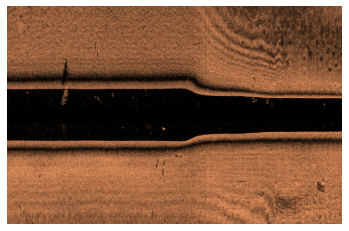

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

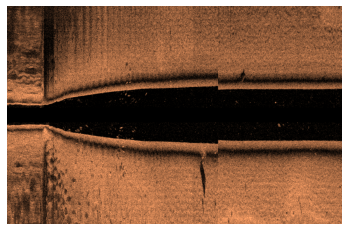

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

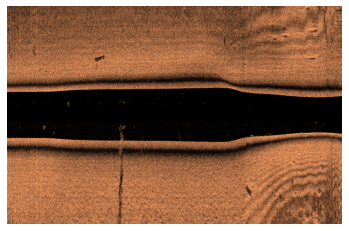

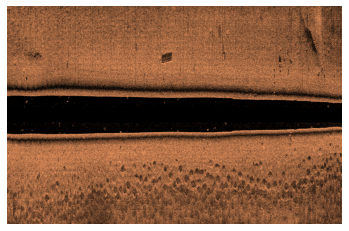

In [30]:
# images with suspected objects
echo = [4,5,8,14,20,21]
size = 800
N = sss_intensity_raw.shape[1]/size
for ii in range(int(np.floor(N))):
    plt.figure()
    im_start = ii*size
    im_end = im_start + size
    for obj_index in echo:
        if ii == obj_index:
            plt.imshow(sss_intensity_raw[:, im_start:im_end], cmap='copper',aspect='auto')
            plt.axis('off')
            #plt.title('{}'.format(ii), fontsize=8)    
            plt.savefig("processed_images/echo_2021-10-16_{}.png".format(ii), bbox_inches='tight')

#### February 22

In [31]:
# Check we can iterate through the selected images
cropped_dataset[files[0]].Y[0]
file_list = [[2,4], [0,8], [0,14], [1,4], [1,9], [3,14], [4,5], [4,11]]
for kk in file_list:
    print(kk)

[2, 4]
[0, 8]
[0, 14]
[1, 4]
[1, 9]
[3, 14]
[4, 5]
[4, 11]


In [40]:
# images with suspected objects
file_list = [[2,4], [0,8], [0,14], [1,4], [1,9], [3,14], [4,5], [4,11]]
size = 800
for jj in range(len(files)):
    N = cropped_dataset[files[jj]].echo.shape[1]/size
    for ii in range(int(np.floor(N))):
        plt.figure()
        im_start = ii*size
        im_end = im_start + size
        for obj_index in file_list:
            if [jj,ii] == obj_index:
                plt.imshow(cropped_dataset[files[jj]].echo[:, im_start:im_end], cmap='copper',aspect='auto')
                plt.axis('off')
                #plt.title('file: {}, im: {}'.format(jj, ii), fontsize=8)
                plt.savefig("processed_images/echo_2022-01-20_{}_{}.png".format(jj,ii), bbox_inches='tight')
                # fig, ax = plt.subplots()
                # ax.plot(cropped_dataset[files[jj]].X, cropped_dataset[files[jj]].Y, 'ko', ms=0.5)
                # ax.plot(cropped_dataset[files[jj]].X[im_start:im_end], cropped_dataset[files[jj]].Y[im_start:im_end], 'ro', ms=0.5)
                # ax.set_aspect('equal')

#### May 22

In [39]:
# images with suspected objects
file_list = [[1,3],[1,10],[2,1],[2,4]]
size = 800
jj = 0
for echo in [echo_3_051722.echo, echo_6_051722.echo, echo_9_051722.echo, echo_12_051722.echo]:
    jj += 1
    N = echo.shape[1]/size
    for ii in range(int(np.floor(N))):
        plt.figure()
        im_start = ii*size
        im_end = im_start + size
        for obj_index in file_list:
            if [jj,ii] == obj_index:
                plt.imshow(echo[:, im_start:im_end], cmap='copper',aspect='auto')
                plt.axis('off')
                #plt.title('file: {}, im: {}'.format(jj, ii), fontsize=8)
                plt.savefig("processed_images/echo_2022-05-17_{}_{}.png".format(jj,ii), bbox_inches='tight')

#### July 2022

In [37]:
# images with suspected objects
file_list = [[1,14],[1,17],[1,21],[1,24],[1,27],[2,2],[2,6],[2,17],[2,29]]
size = 800
jj = 0
for echo in [echo_1_072122.echo, echo_2_072122.echo]:
    jj += 1
    N = echo.shape[1]/size
    for ii in range(int(np.floor(N))):
        plt.figure()
        im_start = ii*size
        im_end = im_start + size
        for obj_index in file_list:
            if [jj,ii] == obj_index:
                plt.imshow(echo[:, im_start:im_end], cmap='copper',aspect='auto')
                plt.axis('off')
                #plt.title('file: {}, im: {}'.format(jj, ii), fontsize=8)
                plt.savefig("processed_images/echo_2022-07-21_{}_{}.png".format(jj,ii), bbox_inches='tight')

### Empty images

#### February 22

In [38]:
# images with suspected objects
empty_list = [
              [0,1],[0,3],[0,5],[0,6],[0,7],[0,9],[0,10],[0,11],[1,0],\
              [1,1],[1,3],[1,6],[3,10],[3,11],[3,12],[4,0],[4,1],[4,3],\
              [4,6],[4,7],[4,9],[4,10],[4,12],[4,13],[4,16],[4,18]\
             ]
size = 800
for jj in range(len(files)):
    N = cropped_dataset[files[jj]].echo.shape[1]/size
    for ii in range(int(np.floor(N))):
        plt.figure()
        im_start = ii*size
        im_end = im_start + size
        for obj_index in empty_list:
            if [jj,ii] == obj_index:
                plt.imshow(cropped_dataset[files[jj]].echo[:, im_start:im_end], cmap='copper',aspect='auto')
                plt.axis('off')
                #plt.title('file: {}, im: {}'.format(jj, ii), fontsize=8)
                #plt.savefig("processed_images/echo_2022-01-20_{}_{}.png".format(jj,ii), bbox_inches='tight')
                plt.savefig("processed_images/empty/echo_2022-01-20_{}_{}.png".format(jj,ii), bbox_inches='tight')
                # fig, ax = plt.subplots()
                # ax.plot(cropped_dataset[files[jj]].X, cropped_dataset[files[jj]].Y, 'ko', ms=0.5)
                # ax.plot(cropped_dataset[files[jj]].X[im_start:im_end], cropped_dataset[files[jj]].Y[im_start:im_end], 'ro', ms=0.5)
                # ax.set_aspect('equal')